# Title: CA-2-AgriProject
* The project must be explored programmatically, this means that you must implement suitable Python tools (code and/or libraries) to complete the analysis required. All of this is to be implemented in a Jupyter Notebook.[0-50]
* The project documentation must include sound justifications and explanation of your code choices. (code quality standards should also be applied) [0-50]


In [ ]:
""" %pip install pandas 
%pip install numpy  
%pip install ipywidgets  
%pip install matplotlib 
%pip install seaborn  
%pip install sklearn 
%pip install pyarrow 
# for web scraping
%pip install beautifuklsoup4 
# for web scraping 
%pip install requests
 # for pdf scraping
%pip install PyPDF2    
%pip install wordcloud """


## Import packages

In [ ]:
from urllib import request as rq
import pandas as pd
import os
import pyarrow as pa # this is needed for the parquet file
import numpy as np
import ipywidgets
from ipywidgets import widgets
from ipywidgets import interact, interactive, fixed, VBox
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from bs4 import BeautifulSoup # for web scraping
import requests # for web scraping
import PyPDF2 # for pdf scraping
from wordcloud import WordCloud   # for word cloud
from wordcloud import STOPWORDS   # for word cloud
from wordcloud import ImageColorGenerator
import re   # for regular expression


## Set up functions

In [43]:
# Function to run the various search page on the IFA site
def searchIFA(searchTerm, pageNumber, header):
    
    if pageNumber == 1:
        url = 'https://www.ifa.ie/?s=' + searchTerm
    else:
        url = 'https://www.ifa.ie/page/' + str(pageNumber) + '/?s=' + searchTerm 
    r =requests.get(url, headers = header)
    soup = BeautifulSoup(r.content)
    return soup


# Function to find the links in the search results
def load_links(soup):
    #print(soup.prettify()) # output the html to a file to see what the structure is like determine that the class is ""col-sm-12 offset-md-2 col-md-10 col-lg-8 offset-lg-2 col-lg-8"" 
    # not needed in the final code, but useful for debugging
    Links = {}
    search_Results = soup.find_all("div", {"class": "col-sm-12 offset-md-2 col-md-10 col-lg-8 offset-lg-2 col-lg-8"})
    type(search_Results) # bs4.element.ResultSet is actually a list of the elements that match the search criteria
    # loop through the pages and extract the links to the articles
    for element in search_Results:
        destFilename = element.find('h3').get_text()
        # tidy the filename and remove / chatracers
        destFilename = destFilename.replace('/', '_')
        url = element.find('a').get('href')
        Links[destFilename] = url
    return Links

# Function to save the html pages as text files    
def resultText(url, destFilename, header):   # save the html pages as text files
    r =requests.get(url, headers = header)
    soup = BeautifulSoup(r.content)
    pageContent = soup.find_all("div", {"class": "single-content"})
    pageTitle = soup.find('h1', {"class": "entry-title"}).get_text()
    try:
        pageDate = soup.find('time', {"class": "entry-date"}).get_text()
        # get last 4 charaters of the date
        pageDate = pageDate[-4:]
        destFilename = destFilename + '_' + pageDate
        for element in pageContent:
            text = element.get_text()
            txtFile = open(destFilename + '.txt', 'w', encoding="utf-8")
            txtFile.writelines(text)
    except:
        print('No date found')
    
    

def shapiro_test(x):
    p_val = stats.shapiro(x)[1]
    status = 'passed'
    color = 'blue'
    if p_val < 0.05:
        status = 'failed'
        color = 'red'
    return status, color, p_val

## TO BE CHANGED
def custom_scatterplot(df1, col1=''):
    df1 = df1[df1["LineID"]==col1]
    f = plt.figure()
    f, ax = plt.subplots(figsize=(11.5, 11.5))
    ax = f.add_subplot(projection='3d')
    ax.scatter(df1['LonWGS84'], df1['LatWGS84'], df1['Hour'], alpha=0.6, color=df1['Colour'])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('Hour')
    dcol = str(col1)
    plt.savefig('./Images/Img_' + dcol + '_Longitude_Latitude_Hour.svg')
    df1.to_parquet('./Data/Bus/LineID_' + dcol + '.parquet')
    
    
def custom_barplot(df1, col1=''):
    if len(df1[col1]) > 5000: # added this to the function because of warnings about the size of data being used with shapiro test
            sampleSize = 5000
    else:
        sampleSize = len(df1[col1])
    df1 = df1.sample(sampleSize) #shapiro test is unreliable over 5000 https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test and performance reasons
    f, ax = plt.subplots(2,2, figsize=(11.5, 11.5))
    ax = ax.reshape(-1)
    df1[col1].plot(ax=ax[0], kind='hist')
    ax[0].set_title('Histogram of {}'.format(col1))
    df1[col1].plot(ax=ax[1], kind='kde')
    ax[1].set_title('Density Plot of {}'.format(col1))
    ax3 = plt.subplot(223)
    stats.probplot(df1[col1], plot=plt)
    ax[2].set_title('QQ Plot of {}'.format(col1))
    df1[col1].plot(ax=ax[3], kind='box')
    ax[3].set_title('Box Plot of {}'.format(col1))
    status, color, p_val = shapiro_test(df1[col1]) 
    f.suptitle('Normality test for {} {} (p_value = {})'.format(col1, status, p_val), color=color, fontsize=12)

def num_missing(x):
    return len(x.index)-x.count()

def num_unique(x):
    return len(np.unique(x))

## TO BE CHANGED 
def load_csv_Files(direc, files):

    for f in files:
        # need to get number of rows to skip 
        temp=pd.read_csv(direc + f,sep='^',header=None,prefix='X')
        temp2=temp.X0.str.split(',',expand=True)
        del temp['X0']
        temp=pd.concat([temp,temp2],axis=1)
        cols = list(range(0,temp.shape[1]))

        print(f)
        yield pd.read_csv(direc + f,  delimiter=',', header=0,  parse_dates=True, low_memory=True, skiprows=14, usecols=cols, na_values='NAN')


def rewriteFile(inFilename):
    inFile = open(inFilename, 'r', encoding="utf-8")
    text = inFile.read()
    yrNum = re.findall(r'\d{2}', inFilename)
    yrNum = str(yrNum[0]) # make sure that this is a string as I want to concatenate it
    outFilename = inFilename.replace(yrNum + '-A.txt', '19' + yrNum + '.txt')
    outFile = open(outFilename, 'a', encoding="utf-8")
    outFile.writelines(text) 
    outFile.close()
    inFile.close()
    os.remove(inFilename)

## Ensure that the folder structure is present in the workspace

In [ ]:
if os.path.exists('./Data'):
    print('Data folder exists')
else:
    os.makedirs('./Data/Raw/IGA/')
    os.makedirs('./Data/Raw/IFA/')
    os.makedirs('./Data/Final/')
if os.path.exists('./Images/'):
    print('Images folder exists')
else:
    os.makedirs('./Images/')


# Examining the Relationship Between Silage Price, Quality, and the Price of Animals

### Questions

+ Can python read PDF for sentiment anaylysis?
  + the answer to this is that yes Python has various packages that can extract text from pdf files, but none are particularly good or easy to use.
+ Are free range pigs more profitable than indoor pigs?
+ How does silage quality affect animal prices?
  +  Further to the above how does the price of animal feeds affect the price of animals? 
    + but how do I incorporate sentiment analysis in to this question?


## Abstract

The aim of this project is to examine the relationship between silage and fodder prices and the price of animals, both as live animals being sold into the food chain. The project will also examine the relationship between the quality of silage and the price of animals, and determine if there is a relationship between the quality of silage and the price of animal feed.

Silage is a type of feed that is made by fermenting and preserving green forage crops, such as grass or maize, in a manner that allows it to be stored and fed to livestock over a long period of time. The quality of silage can be affected by several factors, including the type of forage that is used, the method of fermentation and preservation, and the storage conditions.

The price of animals, whether as live animals or as a food product, can be affected by a variety of factors, including the demand for the animals and the supply of the animals. The quality of the feed that the animals are given can also affect their health and growth, which in turn can affect their price. This project will examine historical data from the https://www.irishgrassland.ie/journals/ site to determine if there is a relationship between the quality of silage and the price of animals.



## 1. Introduction

In [ ]:
# Get the data from the project
# Web scraping from https://proxyway.com/guides/web-scraping-with-python#:~:text=Steps%20to%20Build%20a%20Python%20Web%20Scraper%201,parameters.%20...%203%20Step%203%3A%20Write%20the%20Script
url = "https://www.irishgrassland.ie/journals/"
r = requests.get(url)
soup = BeautifulSoup(r.content)
soup = soup.find('table')
soup = soup.find_all('a')

# download the pdfs from Irish Grassland Journal and save them in the Raw folder
# parse the url for the file name
destDir = './Data/Raw/IGA/'
for element in soup:
    url = element.get('href')
    end = url.rfind('_')
    if end > 0 : # set this condition as some of the links do not have the underscore in the file name. And these pdfs do not seem to be relevant to the project
        start = end - 4
        destFilename = destDir + 'Irish Grassland and Animal Production Association Journal_' + url[start:end] + '.pdf'
        rq.urlretrieve(url, destFilename)  

In [ ]:
# extract the text from the pdfs and save them raw folder
# reference https://www.geeksforgeeks.org/working-with-pdf-files-in-python/
destDir = './Data/Raw/IGA/'
files = os.listdir(destDir)
files = filter(lambda f: f.endswith(('.pdf','.PDF')), files)

for f in files:
    pdfFileObj = open(destDir + f, 'rb')
    pdfReader = PyPDF2.PdfReader(pdfFileObj)
    num_pages = len(pdfReader.pages)
    count = 0
    text = ""
    txtFilename = destDir + f.replace('.pdf', '.txt')
    
    while count < num_pages:
        pageObj = pdfReader.pages[count]
        count +=1
        text += pageObj.extract_text()
   
    txtFile = open(txtFilename, 'w', encoding="utf-8")
    txtFile.writelines(text) 
    txtFile.close()



In [ ]:
# Now I need to handle the 4 files with A in the filename
destDir = './Data/Raw/IGA/'
textFiles  = os.listdir(destDir)
textFiles = filter(lambda f: f.endswith(('A.txt')), textFiles)
for f in textFiles:
    rewriteFile(destDir + f)


In [44]:
# download the various articles that show in this search https://www.ifa.ie/?s=silage
# There are 8 pages of results for this search, so I have to loop through the pages and extract the links pages are structured as https://www.ifa.ie/page/2/?s=silage

# header code re engineered from https://stackoverflow.com/questions/41946166/requests-get-returns-403-while-the-same-url-works-in-browser
# only want to declare once in the code
h = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.76 Safari/537.36'} # This is chrome, you can set whatever browser you like

# intialise search and load first page to get the number of pages
soup = searchIFA(searchTerm = 'silage', pageNumber = 1, header = h)

# find the number of pages returned by the search
nav_results = soup.find_all("div", {"class": "nav-links"})
nav_results = nav_results[0].find_all('a')

for element in nav_results:
    if element.getText() == 'Next':
        break
    max_page = element.getText()
    max_page = int(max_page)
destDir = './Data/Raw/IFA/'
# loop through the pages and extract the links
for page in range(1, max_page + 1):
    #print(page)
    soup = searchIFA(searchTerm = 'silage', pageNumber = page, header = h)
    searchLinks = load_links(soup = soup)
    # now that I have the url, I can use beautiful soup to extract the text from the article
    for item in searchLinks:
        destItem = destDir + item
        resultText(url = searchLinks[item], destFilename = destItem, header=h)
   

No date found


In [48]:
# load the text files from the Raw folder and create a dataframe
destDir = './Data/Raw/IGA/'
files = os.listdir(destDir)
files = filter(lambda f: f.endswith(('txt')), files)
text = ""
for f in files:
    file = open(destDir + f, 'r', encoding="utf-8")
    text += file.read()
    file.close()



In [49]:
text = text.lower() # Convert to lowercase
text = text.replace(".", "") # Remove punctuation

In [50]:
# remove stop words
WordCloud1 = WordCloud(stopwords=STOPWORDS, background_color='white', width=1200, height=1000).generate(text)



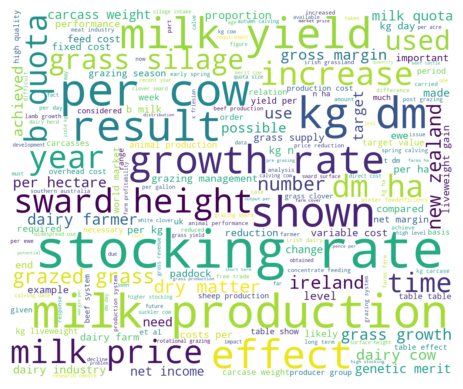

In [51]:
plt.imshow(WordCloud1, interpolation="bilinear")
plt.axis('off')
plt.show()

### 2.1 Business Understanding

### 2.2 Data Understanding

#### Initial look at the data, check for missing data
Discuss in detail the process of acquiring your raw data, detailing the positive and/or negative aspects of your research and acquisition. This should include the relevance and implications of any and all licensing/permissions associated with the data. [0-15]


#### Exploratory data analysis
Exploratory Data Analysis helps to identify patterns, inconsistencies, anomalies, missing data, and other attributes and issues in data sets so problems can be addressed. 

Evaluate your raw data and detail, in depth, the various attributes and issues that you find. Your evaluation should reference evidence to support your  chosen methodology and use visualizations to illustrate your findings.[0-25]


Display the shape and types of data

Describe the numerical data 

Use descriptive statistics and appropriate visualisations in order to summarise the dataset(s) used, and to help justify the chosen models. [0-20]


Set the Numerical and Categorical columns

Analyse the variables in your dataset(s) and use appropriate inferential statistics to gain insights on possible population values 

(e.g., if you were working with international commerce, you could find a confidence interval for the population proportion of yearly dairy exports out of all agricultural exports). [0-20]


Display plots from the Data set, including Histograms, pairplots, boxplots and correlation
* possibly use seaborn reg plots to check linear regression from the correlation plots 

Undertake research to find similarities between some country(s) against Ireland, and apply parametric and non-parametric inferential statistical techniques to compare them 

(e.g., t-test, analysis of variance, Wilcoxon test, chi-squared test, among others). 

You must justify your choices and verify the applicability of the tests. Hypotheses and conclusions must be clearly stated. 

You are expected to use at least 5 different inferential statistics tests. [0-40]


Check for Outliers

Use the outcome of your analysis to deepen your research. 

Indicate the challenges you faced in the process. [0-20]

Check distributions of the data 

### 2.3 Data Preparation

All data frame changes go in this section, including the reasons for making the changes.

Taking into consideration the tasks required in the machine learning section, use appropriate data cleaning, engineering, extraction and/or other techniques to structure and enrich your data. 

Rationalize your decisions and implementation, including evidence of how your process has addressed the problems identified in the EDA (Exploratory Data Analysis) stage and how your structured data will assist in the analysis stage. 

This should include visualizations to illustrate your work and evidence to support your methodology.[0-30]


Collect and develop a dataset based on the agriculture topic related to Ireland as well as other parts of the world. 

Perform a sentimental analysis for an appropriate agricultural topic (e.g., product price, feed quality etc…) for producers and consumers point of view in Ireland.
[0 - 25]


### 2.4 Modeling

Clustering, Linear regression, random forest.

Use of multiple models (at least two) to compare and contrast results and insights gained.

Describe the rationale and justification for the choice of machine learning models for the above-mentioned scenario. 

Machine Learning models can be used for Prediction, Classification, Clustering, sentiment analysis, recommendation systems and Time series analysis. 

You should plan on trying multiple approaches (at least two) with proper selection of hyperparameters using GridSearchCV method. 

You can choose appropriate features from the datasets and a target feature to answer the question asked in the scenario in the case of supervised learning.
[0 - 30]


You should train and test for Supervised Learning and other appropriate metrics for unsupervised/ semi-supervised machine learning models that you have chosen. 

Use cross validation to provide authenticity of the modelling outcomes. 

You can apply dimensionality reduction methods to prepare the dataset based on your machine learning modelling requirements.
[0 - 30]


### 2.5 Evaluation

A Table or graphics should be provided to illustrate the similarities and contrast of the Machine Learning modelling outcomes based on the scoring metric used for the analysis of the above-mentioned scenario. 

Discuss and elaborate your understanding clearly.
[0 - 15]


## Results

## Conclusion

## Acknowledgements

## References

# Notes:
Additional notes : 
All:
* Your documentation should present your approach to the project, including elements of project planning ( timelines). 
* Ensure that your documentation follows a logical sequence through the planning / research / justification / implementation phases of the project. 
* Ensure that your final upload contains a maximum of 1 jupyter notebook per module.
* Please ensure that additional resources are placed and linked to a logical file structure eg, Scripts, Images, Report, Data etc…
* Ensure that you include your raw and structured datasets in your submission
* 3000(+/- 10%) words in report (not including code, code comments, titles, references or citations) 
* Your Word count MUST be included
